<a href="https://colab.research.google.com/github/be1le/machine-learning/blob/main/Co4Team.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import functools #호출 가능한 객체에 대한 고차 함수 관련 함수 //https://docs.python.org/3/library/functools.html
import os #운영체제(OS : Operating System)를 제어할 수 있다.


from matplotlib import gridspec #Figure 내에 서브 플롯을 배치하기 위한 그리드 레이아웃.
import matplotlib.pylab as plt #matplotlib을 설치할 때 같이 설치되는 모듈중 하나로 
#matplotlib.pyplot과 numpy를 하나의 네임 스페이스에 임폴트 시키는 역할을 한다.
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

TF Version:  2.8.0
TF Hub version:  0.12.0
Eager mode enabled:  True
GPU available:  []


In [ ]:
def crop_center(image):#정사각형으로 이미지를 반환하는 함수
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image
  
@functools.lru_cache(maxsize=None)#이미지를 로드하고 전처리 하는 함수
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  #로컬로 이미지 다시 가져오기
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  #이미지 로드후 float32 넘파이 행렬로 바꿔주기 배치범위 증가후 [0,1]범위에서 정규화
  img = tf.io.decode_image(
      tf.io.read_file(image_path),
      channels=3, dtype=tf.float32)[tf.newaxis, ...]
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):#출력된 이미지를 시각화하는 함수
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()


  16384/Unknown - 0s 0us/step

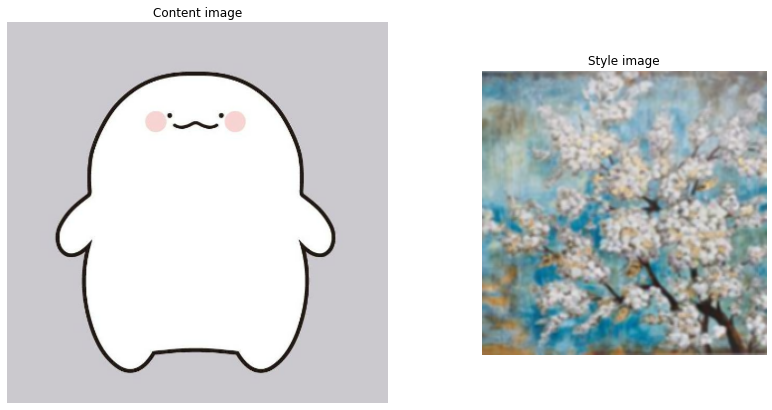

In [ ]:

content_image_url ='https://scontent-ssn1-1.xx.fbcdn.net/v/t1.6435-9/53255434_2329724433745003_7992728773994741760_n.jpg?_nc_cat=108&ccb=1-5&_nc_sid=09cbfe&_nc_ohc=s0lT9D3EuiQAX-cFstZ&_nc_ht=scontent-ssn1-1.xx&oh=00_AT8yaQaE14xVunwhCKYEFaye1FZxpYc-BGz7BnZFl1Zi5g&oe=62527324'  
style_image_url = 'https://image.made-in-china.com/43f34j10AbTfomMalBqO/Hand-Painted-Impression-Oil-Artworks-Famous-Painting-Reproduction-for-House-Decoration-Cherry-Blossoming-Tree-Branches-Size-40X30inch.jpg'  
output_image_size = 384 

#content img사이즈는 임의로 달라질수 있다. 
content_img_size = (output_image_size, output_image_size)
#import 해온 스타일예측 모델은 256사이즈로 트레이닝 되어서 가능한한 256사이즈의 스타일 이미지를
#사용하는 것이 결과예측에 큰 도움이 됩니다. 
style_img_size = (256, 256)  # 가능한한  256으로 사용.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

In [ ]:
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

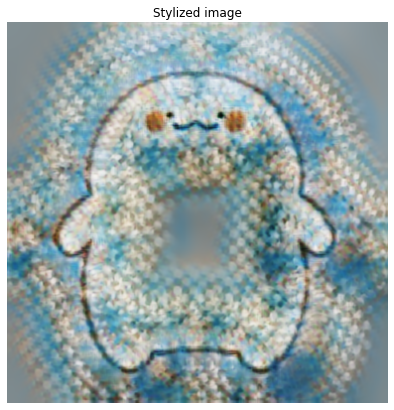

In [ ]:
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]
show_n([stylized_image],titles=['Stylized image'])